<a href="https://colab.research.google.com/github/nrush23/Machine-Learning-2022/blob/main/Kouh_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose Detection with OpenPose

This notebook uses an open source project [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git) to detect/track multi person poses on a given youtube video.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install OpenPose

In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  #!pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

## Detect poses on a test video

We are going to detect poses on the following youtube video:

Download the above youtube video, cut the first 5 seconds and do the pose detection on that 5 seconds:

In [ ]:
#!rm -rf youtube.mp4
# download the youtube with the given ID
#!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# cut the first 5 seconds
#!ffmpeg -y -loglevel info -i youtube.mp4 -t 5 video.mp4
# detect poses on the these 5 seconds
!rm openpose.avi
!cd openpose && ./build/examples/openpose/openpose.bin --video ../video6.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

In [ ]:
#I use these commands to zip and download the openpose output after it
#processes my videos
!zip -r /content/file.zip /content/openpose/output
from google.colab import files
files.download("/content/file.zip")

In [ ]:
import os
from os.path import exists, join, basename, splitext

#function to delete files in my output folder after I finish running them
def deleteFiles():
  rawFiles = os.listdir('/content/openpose/output')
  for file in rawFiles:
    os.remove('/content/openpose/output/' + file)

def deleteFiles2(path):
  rawFiles = os.listdir('/content/testFolder')
  for file in rawFiles:
    os.remove(path + '/' + file)

deleteFiles2('/content/testFolder')

In [ ]:
#I unzip my openpose files because I didn't set up a pathway to my google drive
!unzip /content/output.zip -d /content/

<h1>Here are my functions after I've worked on them for a while. The original ones I started with are below these 2 cells</h1>

In [64]:
import os
from os.path import exists, join, basename, splitext
import json
import matplotlib.pyplot as plt

data = [];

#this is my default output path because I unzip my raw jsons.
#Takes all the jsons and puts them into one data array to be
#accessed in getCoord()
def sortFiles():
  rawFiles = os.listdir('/content/OpenPose Sample Output')
  rawFiles.sort()
  for file in rawFiles:
    openFile = open('/content/OpenPose Sample Output/' + file)
    data.append(json.load(openFile))
    openFile.close()

def sortFiles2(fileName):
  rawFiles = os.listdir('/content/OpenPose Sample Output')
  rawFiles.sort()
  for file in rawFiles:
    if fileName in file:
      openFile = open('/content/OpenPose Sample Output/' + file)
      temp = json.load(openFile)
      if len(temp['people']) == 0:
        temp = {'version': 1.3, 'people':[{'person_id': [-1], 'pose_keypoints_2d':[0]*75}]}
      data.append(temp)
      # data.append(json.load(openFile))
      openFile.close()

#the function that actually lets us retrieve our coordinate values
#I realized the pattern for accessing a specific keypoint's coordinate is
#array position = ((keypoint - 1) * 3) + (0 or 1 depending on if it's x or y)
def getCoord(frame, keypoint, coord):
  if coord == 'x':
    coord = 0
  else:
    coord = 1
  return data[frame]['people'][0]['pose_keypoints_2d'][(keypoint - 1) * 3 + coord]


#if you need a specific keypoint array, use this function to get those keypoints.
#You specify which frames to start and end at, function is inclusive
def getKpArray(frameStart, frameEnd, keypoint):
  kp=[];
  for frame in range(frameStart, frameEnd + 1):
    kp.append(getCoord(frame, keypoint, 'x'))
    kp.append(getCoord(frame, keypoint, 'y'))
  return kp


#gets all the x and y coordinates so that we can make a scatterplot
#offsets the x value by 800 per frame so the sticks aren't on top
#of eachother. The y is negative because the stick figures were upside down
def displayGraph(frameStart, frameEnd):
  xCords=[]
  yCords=[]
  for frame in range(frameStart, frameEnd + 1):
    for kp in range(0,26):
      xCords.append(getCoord(frame,kp,'x') + frame * 800)
      yCords.append(-getCoord(frame,kp,'y'))
  plt.scatter(xCords, yCords)
  plt.show()
  

sortFiles2('Ashita2_')
  

In [ ]:
print(len(data))

In [73]:
import csv
# sortFiles2()
def getCSV():
  file = open('/content/empty.csv', 'w')
  writer = csv.writer(file)
  row = ['Frame']
  for num in range(1,26):
    row.append('x' + str(num))
    row.append('y' + str(num))
  writer.writerow(row)
  for x in range (0, len(data)):
    row = [x]
    for kp in range (1,26):
      row.append(getCoord(x,kp,'x'))
      row.append(getCoord(x,kp,'y'))
    writer.writerow(row)
  file.close()

getCSV()


In [ ]:
from google.colab import files
sortFiles2('Jai1')
getCSV()
data.clear()
files.download('empty.csv')

In [ ]:
data.clear()
print(data)

In [ ]:
row = {'version': 1.3, 'people':[{'person_id': [-1], 'pose_keypoints_2d':[0]*50}]}
print(row)
print(data[0])

In [31]:
import csv

file = open('/content/test.csv', 'w')
writer = csv.writer(file)
writer.writerow(data)
file.close()

In [ ]:
kp1 = getKpArray(0,len(data)-1,1)

for x in range (0, len(kp1), 2):
  print(kp1[x])

In [ ]:
import os
from os.path import exists, join, basename, splitext
import json
import matplotlib.pyplot as plt

data = [];

def sortFiles2():
  kp = []
  rawFiles = os.listdir('/content/ashitaFiles')
  rawFiles.sort()
  for file in rawFiles:
    openFile = open('/content/ashitaFiles/' + file)
    data = json.load(openFile)
    # print(data['people'][0]['pose_keypoints_2d'][0])
      # pair.append(data['people'][0]['pose_keypoints_2d'][((keypoint - 1) * 3)])
      # pair.append(data['people'][0]['pose_keypoints_2d'][((keypoint - 1) * 3 + 1)])
      # kp.append(pair)
    openFile.close()
  # return kp


# kp1 = sortFiles2()

# print(kp1)

# sortFiles2()
print(data['people'])

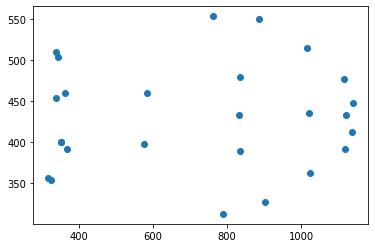

1121.97


In [42]:
sortFiles()

displayGraph(0,0)

print(getCoord(0,1,'x'))

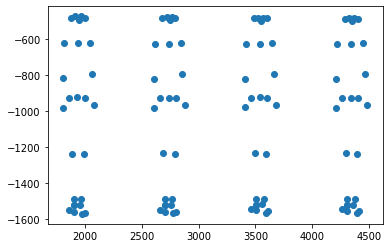

In [ ]:
import matplotlib.pyplot as plt


#gets all the x and y coordinates so that we can make a scatterplot
#offsets the x value by 800 per frame so the sticks aren't on top
#of eachother. The y is negative because the stick figures were upside down
def displayGraph(frameStart, frameEnd):
  xCords=[]
  yCords=[]
  for frame in range(frameStart, frameEnd + 1):
    for kp in range(0,26):
      xCords.append(getCoord(frame,kp,'x') + frame * 800)
      yCords.append(-getCoord(frame,kp,'y'))
  plt.scatter(xCords, yCords)
  plt.show()

displayGraph(0,3)


<h1>Previous code I was working with </h1>

In [ ]:
import os
from os.path import exists, join, basename, splitext
import json 


#in future someone can research into making 2d array for python
#or focus on using that getCoord() function
kp1=[];
kp2=[];
kp3=[];
kp4=[];
kp5=[];
kp6=[];
kp7=[];
kp8=[];
kp9=[];
kp10=[];
kp11=[];
kp12=[];
kp13=[];
kp14=[];
kp15=[];
kp16=[];
kp17=[];
kp18=[];
kp19=[];
kp20=[];
kp21=[];
kp22=[];
kp23=[];
kp24=[];
allKps=[kp1,kp2,kp3,kp4,kp5,kp6,kp7,kp8,kp9,kp10,kp11,kp12,kp13,kp14,kp15,kp16,kp17,kp18,kp19,kp20,kp21,kp22,kp23,kp24]

data = [];

#for future work, we could retrieve coordinates on the fly like this
#rather than filter them into individual arrays
def getCoordWIP(frame, keypoint, coord):
  return data['people'][0]['pose_keypoints_2d'][frame][keypoint][coord]


#original file sort function that got the data from the jsons
def sortFilesOg():
  rawFiles = os.listdir('/content/content/openpose/output')
  rawFiles.sort()
  for file in rawFiles:
    openFile = open('/content/output/content/openpose/output/' + file)
    rawData = json.load(openFile)
    data.append(rawData['people'][0]['pose_keypoints_2d'])
    openFile.close()

#function that cycles through a list of files and adds their key points to the individual key point arrays
def setKp(data):
    for frame in range(0, len(data)):
      position = 0
      for kp in allKps:
        kp.append(data[frame][position:position + 2])
        position += 3





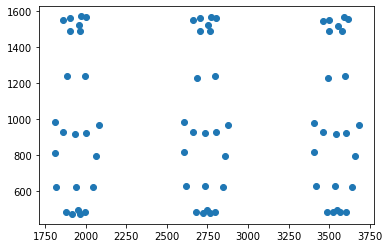

In [ ]:
import matplotlib.pyplot as plt


#displays the points from the 0th frame to the one you specify

def displayGraphOg(frames):
  xCords=[];
  yCords=[];  
  for frame in range(0, frames):
    for kp in allKps:
      xCords.append(kp[frame][0] + frame * 800)
      yCords.append(kp[frame][1])
  plt.scatter(xCords, yCords)
  plt.show()

displayGraphOg(3)


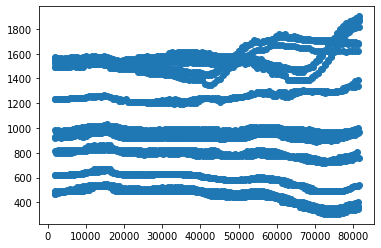

In [ ]:
displayGraph(100)

Finally, visualize the result:

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)